# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# Импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import random
import time
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor


In [2]:
# Выведем датафрейм и изучим признаки
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

# Выведем датафрейм 
display(df)
display(df.describe())
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
# Создадим функцию, которая выведет количество пропущенных значений, дубликатов и уникальныъ значений таблиц
def information(data):
    for i in data.columns:
        print(f'\nУникальные значения {i}:\n', data[i].unique())
    print('\nКоличество пропущенных значений:\n', data.isna().sum())
    print('\nКоличество дубликатов в датафрейме:', data.duplicated().sum())

In [4]:
# Получим информацию по нашему датафрейму
information(df)


Уникальные значения DateCrawled:
 ['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']

Уникальные значения Price:
 [  480 18300  9800 ... 12395 18429 10985]

Уникальные значения VehicleType:
 [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Уникальные значения RegistrationYear:
 [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450

**Вывод:** 
* В датафрейме присутствуют таблицы, в которых необходимо изменить формат на дату (DateCrawled, DateCreated, LastSeen)
* Столбец года регистрации автомобиля (RegistrationYear) скоректируем по правильным годам
* Отсеим значения цены равное 0.
* Столбец значения месяца заменим с помощью рандомных чисел в диапозоне от 1 до 12.
* Значения таблицы тип топлива (FuelType), пустые значения заменим на other
* Заменим пустые значения таблицы модели машины (Model) на other
* Столбец типа коробки передач (Gearbox) заполним пустые значения на другое (other), так как помимо механической и автомотизированной коробки передач, есть еще роботизированные и Вариативная (бесступенчатая) коробки переключения передач.
* Произведем замены в таблице NotRepaired и заменим пропущенные значения на unknown.
* Подкариктируем столбец мощности (Power) 
* Заменим пустые значения в таблице тип автомобильного кузова (VehicleType) по модели (Model).
* Удалим дубликаты
* Удалим ненужные столбцы мешающие обучению модели



### Обработка таблиц  DateCrawled, DateCreated, LastSeen

In [5]:
# Изменим формат перечисленных таблиц на формат даты и время с помощью метода apply
df[['DateCrawled', 'DateCreated', 'LastSeen']] = df[['DateCrawled', 
                                                     'DateCreated', 
                                                     'LastSeen']].apply(pd.to_datetime,
                                                                        format='%Y-%m-%d %H:%M:%S')
# Проверим полученные изменения
df.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
Repaired                     object
DateCreated          datetime64[ns]
NumberOfPictures              int64
PostalCode                    int64
LastSeen             datetime64[ns]
dtype: object

Теперь определим когда в последний раз были скачены анкеты из базы, а также определим, когда были созданы первые анкеты

In [6]:
# Выведем таблицу с датами скачиванния анкеты из базы
df['DateCrawled'].sort_values(ascending=False)

90713    2016-04-07 14:36:58
339649   2016-04-07 14:36:56
301030   2016-04-07 14:36:55
53739    2016-04-07 14:36:54
204218   2016-04-07 14:36:53
                 ...        
99885    2016-03-05 14:06:24
324763   2016-03-05 14:06:24
176823   2016-03-05 14:06:24
220583   2016-03-05 14:06:23
329497   2016-03-05 14:06:22
Name: DateCrawled, Length: 354369, dtype: datetime64[ns]

In [7]:
# Выведем таблицу с датой создания анкеты 
df['DateCreated'].sort_values(ascending=False)

323825   2016-04-07
238423   2016-04-07
218464   2016-04-07
8823     2016-04-07
136456   2016-04-07
            ...    
175103   2015-08-10
86601    2015-08-07
342275   2015-06-18
4001     2015-03-20
61207    2014-03-10
Name: DateCreated, Length: 354369, dtype: datetime64[ns]

**Вывод:** Последний раз анкеты с базами данных вытаскивали 7 апреля 2016 года, а первая же публикация анкеты была зафиксированна 10 марта 2014 года. Так как нам необходимо скоректировать столбец с годами регистрации автомобиля, то максимальный порог зафиксируем на 2016 годе. 

### Обработка таблицы RegistrationYear

In [8]:
pd.Series(df['RegistrationYear'].unique()).sort_values()

70     1000
118    1001
133    1039
39     1111
102    1200
       ... 
91     9000
143    9229
119    9450
134    9996
67     9999
Length: 151, dtype: int64

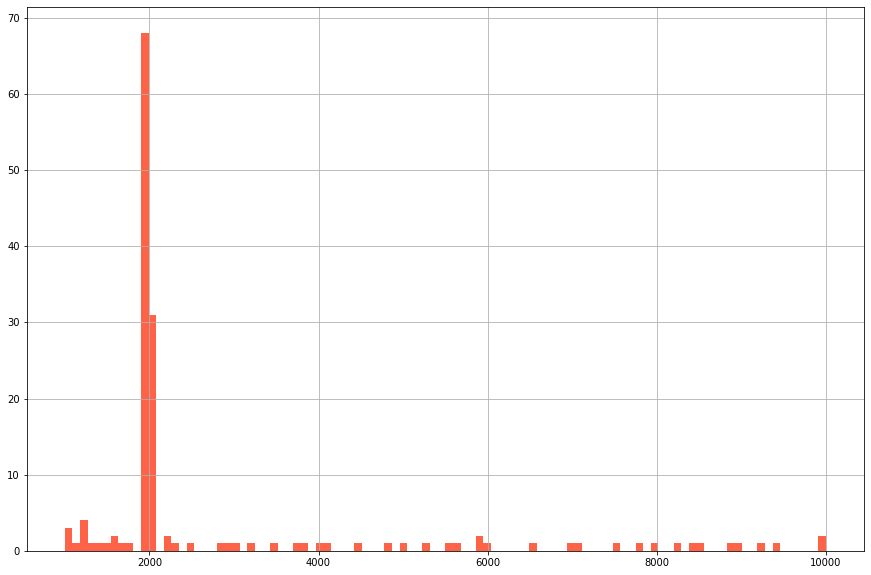

In [9]:
# Построим график года регистрации автомобиля по уникальным значениям в столбце
pd.Series(df['RegistrationYear'].unique()).sort_values().hist(bins=100, 
                                                              figsize=(15,10), 
                                                              color='tomato');

Установим диапозон значений регистраций автомобиля в диапозоне с 1900 года по 2017 год, так активная регистрация и автомобилей началось имненно в 19 веке.

In [10]:
# Устанавливаем диапозон значений регистраций автомобилей
df=df.query('1900 <= RegistrationYear < 2017')

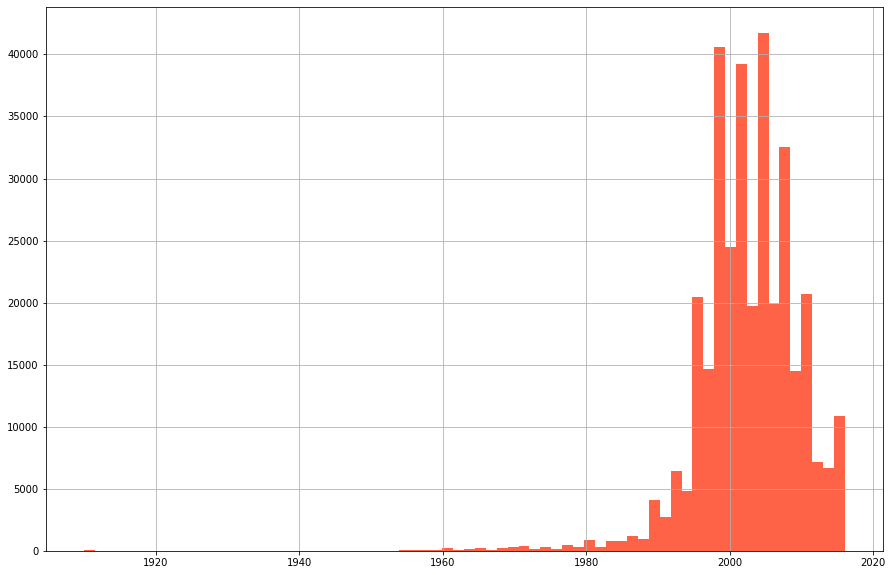

In [11]:
# Построим график года регистрации автомобиля
df['RegistrationYear'].hist(bins=70, figsize=(15,10), color='tomato');

### Обработка таблицы Price

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11,0,27432,2016-03-12 23:47:10
154,2016-03-22 16:37:59,0,NaN,2006,NaN,0,other,5000,0,NaN,fiat,NaN,2016-03-22,0,44867,2016-04-06 06:17:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32


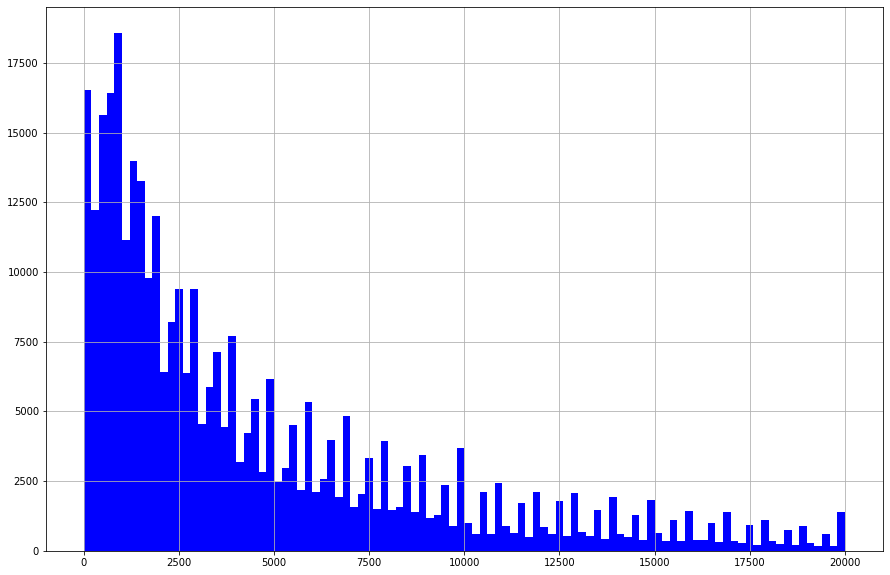

In [12]:
# Проверим целевой признак цены по графику
df['Price'].hist(bins=100, figsize=(15,10), color='blue');

# Проверим сколько данных имют нулевую цену
df.query('Price==0')

**Вывод:** 10772 значения имеют нулевую цену, установим минимальное значение стоимости автомобиля.

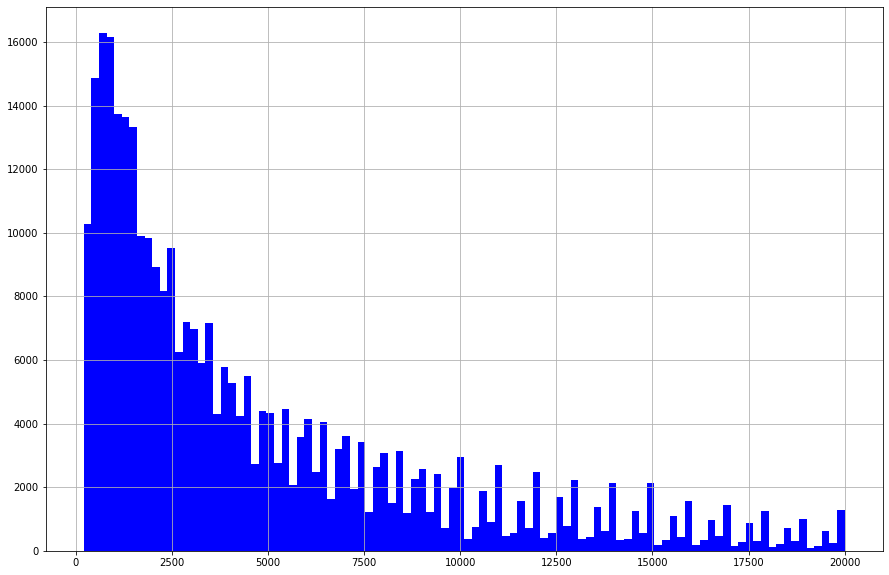

In [13]:
# Отсеим значения меньше 200 евро
df = df.query('Price>200')

# Проверим целевой признак цены по графику
df['Price'].hist(bins=100, figsize=(15,10), color='blue');


### Обработка таблицы RegistrationMonth

In [14]:
# Создадим генерацию случайных чисел в диапозоне от 1 до 12 и сохраним в переменную d
d = random.randint(1,12)

In [15]:
# Передадим значения с числами 0 значения случайных чисел
df.loc[df['RegistrationMonth'] == 0,'RegistrationMonth'] = d

# Проверим количество уникальных значений 
df['RegistrationMonth'].unique()

array([ 9,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4])

### Обработка таблиц FuelType, Gearbox, Model

In [16]:
# Заполняем пустые значения в таблицах на other
df[['FuelType', 'Gearbox', 'Model']] = df[['FuelType', 'Gearbox', 'Model']].fillna('other')

# Проверим произведенные замены
df['FuelType'].unique()

array(['petrol', 'gasoline', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

### Обработка таблицы Power

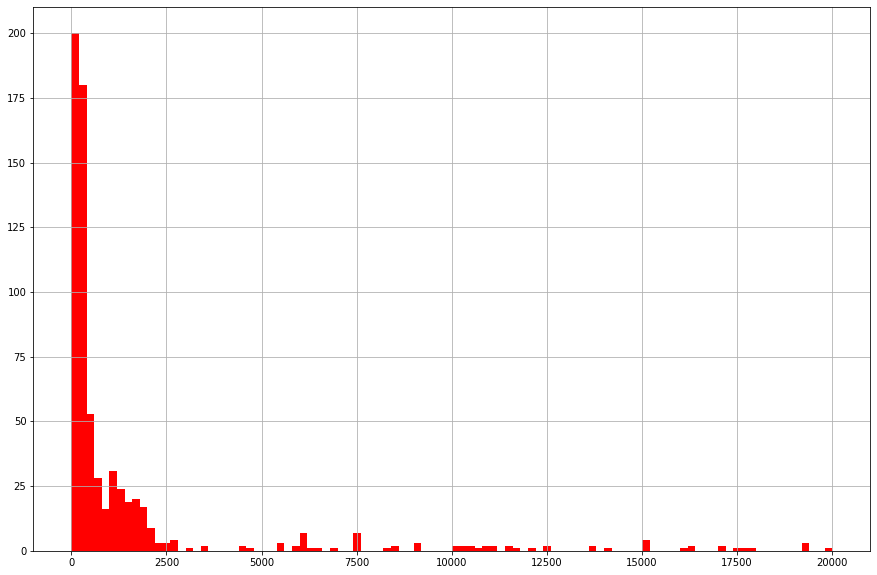

In [17]:
pd.Series(df['Power'].unique()).sort_values().hist(bins=100, figsize=(15,10), color='red');

Выставим диапозон мощностей двигателей от 10 до 2000 л.с. выше этого значеня машин не существует. 

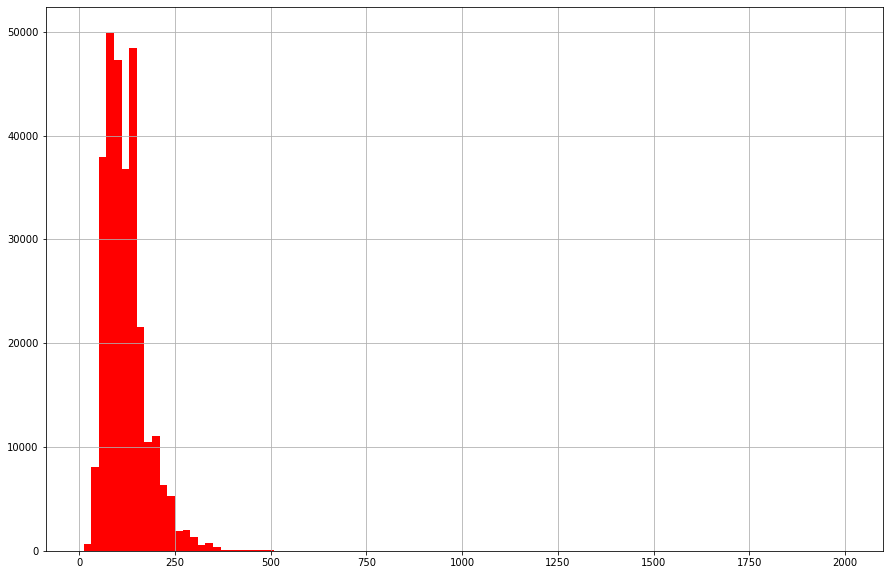

In [18]:
# Отсеим значения меньше 0
df = df.query('10<Power<2000')
# Проверим целевой признак цены по графику
df['Power'].hist(bins=100, figsize=(15,10), color='red');

### Обработка таблицы Repaired

In [19]:
# Заменим пустые значения на unknown
df['Repaired'] = df['Repaired'].fillna('unknown')
df['Repaired'].unique()

array(['yes', 'unknown', 'no'], dtype=object)

### Обработка таблицы VehicleType

In [20]:
# Создадим данные из таблиц по моделям
sk = df.groupby('Model')['VehicleType'].agg('unique')
sk

Model
100                  [sedan, wagon, nan, coupe, convertible]
145                        [small, sedan, coupe, nan, other]
147                 [sedan, small, wagon, coupe, nan, other]
156                        [wagon, sedan, nan, coupe, small]
159                                      [sedan, wagon, nan]
                                 ...                        
yaris                 [small, bus, other, nan, wagon, sedan]
yeti                                [suv, nan, other, wagon]
ypsilon                                         [small, nan]
z_reihe                          [convertible, coupe, sedan]
zafira     [bus, nan, other, wagon, small, sedan, suv, co...
Name: VehicleType, Length: 249, dtype: object

Отсеим пустые значения, но так чтобы они данные таблицы VehicleType, заполнялись по определенной модели.

In [21]:
# Отсеим  пустые значения с помощью метода mode
df['VehicleType'] = df['VehicleType'].fillna(df['VehicleType'].mode()[0])
df['VehicleType']

1               coupe
2                 suv
3               small
4               small
5               sedan
             ...     
354361          sedan
354362          sedan
354366    convertible
354367            bus
354368          wagon
Name: VehicleType, Length: 291367, dtype: object

Количество данных осталось прежним

### Удаление дубликатов

In [22]:
# Удаляем дубликаты в датафрейме
df = df.drop_duplicates()
df.duplicated().sum()

0

In [23]:
# Проверим данные на количество пропусков
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Данные обрабатоны, теперь избавимся от признаков, не влияющие на обучение модели.

Оставим более значимые таблицы для создания модели: 
* Тип автомобильного кузова (VehicleType)
* тип коробки передач (Gearbox)
* Мощность (Power)
* Модель автомобиля (Model)
* Пробег (Kilometer)
* Бренд (Brand)
* Тип топлива (FuelType)
* Год регистрации автомобиля (RegistrationYear) 
* Месяц регистрации автомобиля (RegistrationMonth)

Избавимся от таблиц, так как они в дальнейшем могут помещать процессу обучения:
* Дата создания анкеты (DateCreated)
* Количество фотографий автомобиля (NumberOfPictures)
* Почтовый индекс владельца анкеты (PostalCode)
* дата последней активности пользователя (LastSeen)
* дата скачивания анкеты из базы (DateCrawled)

In [24]:
# Удаляем не нужные столбцы
df = df = df.drop(['DateCreated', 
                   'NumberOfPictures', 
                   'DateCrawled', 
                   'PostalCode', 
                   'LastSeen'], axis=1)

**Вывод:** Датафрейм обработан, пропусков нет, лишнее таблицы удалены, теперь можно делить фрейм на тренировачную и тестевую выборку.

## Обучение моделей

Создадим списки категориальных и численных признаков. В Дальнейшем по ним произвдем кодирование.

In [25]:
# Создадим список с категориальными признаками
cat_features = df.select_dtypes(include='object').columns.to_list()
print(cat_features)

# Выведем численные признаки
num_features = df.select_dtypes(exclude='object').columns.to_list()

# Удалим целевой признак Price
num_features.remove('Price')
print(num_features)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


In [26]:
# Сбросим индексы, чтобы лишние и битые значения в котегориальных признаках были нормально 
# трансформированы в цифровой формат

df = df.reset_index(drop=True)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...,...
291358,5250,sedan,2016,auto,150,159,150000,12,other,alfa_romeo,no
291359,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
291360,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
291361,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [27]:
# Разделим датафрейм на основную и целевую выборку
features = df.drop(['Price'], axis=1)
target = df['Price']

In [28]:
# Разделим данные на тренировачную и тестевую выборки
train_features, test_features, train_target, test_target = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=15)
# Поделим тестевую выборку на части
train_feat_valid, test_feat_valid, tar_train_valid, tar_test_valid = train_test_split(test_features, test_target, 
                                                                            test_size=0.5, random_state=15)

In [29]:
# Закадируем тренеровачную выборку
encoder = OrdinalEncoder()

# Обучим encoder на тренеровачной выборке
encoder.fit(train_features[cat_features])

# Закадируем тренеровачную выборку
train_features[cat_features] = encoder.transform(train_features[cat_features])
train_features

/tmp/ipykernel_78/3699394716.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[cat_features] = encoder.transform(train_features[cat_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
10297,6.0,2008,0.0,315,243.0,150000,4,6.0,39.0,0.0
99114,5.0,2003,1.0,60,8.0,150000,12,6.0,25.0,0.0
241540,4.0,2001,0.0,275,170.0,150000,10,6.0,38.0,0.0
12041,4.0,2012,1.0,179,42.0,40000,4,6.0,24.0,0.0
190017,5.0,2013,1.0,110,126.0,40000,8,2.0,23.0,0.0
...,...,...,...,...,...,...,...,...,...,...
104832,1.0,2002,0.0,54,106.0,100000,2,6.0,32.0,0.0
180087,7.0,2005,0.0,131,29.0,150000,7,4.0,1.0,0.0
199301,5.0,2010,1.0,75,166.0,125000,10,6.0,19.0,0.0
270220,4.0,2002,1.0,150,11.0,150000,10,2.0,2.0,0.0


In [30]:
# Закадируем тестовую выборку
test_features[cat_features] = encoder.transform(test_features[cat_features])
test_features

/tmp/ipykernel_78/2616426292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[cat_features] = encoder.transform(test_features[cat_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
31842,4.0,1989,0.0,139,166.0,150000,12,6.0,33.0,0.0
100683,0.0,1974,1.0,50,223.0,100000,12,6.0,38.0,0.0
90886,4.0,1994,0.0,90,170.0,5000,9,6.0,38.0,0.0
111299,4.0,2005,1.0,105,42.0,100000,5,6.0,24.0,0.0
260509,4.0,2012,0.0,140,42.0,40000,11,6.0,24.0,0.0
...,...,...,...,...,...,...,...,...,...,...
23250,7.0,2002,1.0,100,248.0,150000,3,0.0,24.0,2.0
175471,7.0,1994,1.0,71,42.0,150000,9,6.0,24.0,0.0
248723,4.0,2012,0.0,184,6.0,90000,4,2.0,2.0,0.0
126760,5.0,2004,1.0,60,35.0,150000,1,6.0,24.0,2.0


In [31]:
# Закадируем валидационную выборку
train_feat_valid[cat_features] = encoder.transform(train_feat_valid[cat_features])
train_feat_valid

/tmp/ipykernel_78/2819239487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_feat_valid[cat_features] = encoder.transform(train_feat_valid[cat_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
28947,5.0,2014,0.0,75,227.0,20000,1,6.0,38.0,0.0
158715,5.0,2006,1.0,65,166.0,150000,3,6.0,9.0,2.0
115323,7.0,2007,0.0,163,11.0,150000,1,2.0,2.0,0.0
41795,4.0,2006,1.0,105,42.0,150000,5,6.0,24.0,0.0
163739,4.0,1996,1.0,60,116.0,150000,10,6.0,38.0,0.0
...,...,...,...,...,...,...,...,...,...,...
101770,4.0,1996,1.0,170,15.0,150000,12,5.0,2.0,1.0
233049,2.0,2007,0.0,231,11.0,150000,10,2.0,2.0,0.0
24359,7.0,2003,0.0,163,29.0,150000,6,5.0,1.0,0.0
39246,4.0,2004,1.0,82,166.0,150000,9,2.0,12.0,2.0


In [32]:
# создаём скелер
scaler = StandardScaler()
# обучаем его на тренеровачной выборке
scaler.fit(train_features[num_features])

# Закадируем его на тренеровачной выборке
train_features[num_features] = scaler.transform(train_features[num_features])

# смотрим на результат
train_features

/tmp/ipykernel_78/3136159414.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[num_features] = scaler.transform(train_features[num_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
10297,6.0,0.782876,0.0,3.097539,243.0,0.593445,-0.767238,6.0,39.0,0.0
99114,5.0,0.014879,1.0,-0.997704,8.0,0.593445,1.651953,6.0,25.0,0.0
241540,4.0,-0.292320,0.0,2.455148,170.0,0.593445,1.047155,6.0,38.0,0.0
12041,4.0,1.397274,1.0,0.913410,42.0,-2.403148,-0.767238,6.0,24.0,0.0
190017,5.0,1.550873,1.0,-0.194715,126.0,-2.403148,0.442357,2.0,23.0,0.0
...,...,...,...,...,...,...,...,...,...,...
104832,1.0,-0.138720,0.0,-1.094063,106.0,-0.768643,-1.372036,6.0,32.0,0.0
180087,7.0,0.322078,0.0,0.142540,29.0,0.593445,0.139959,4.0,1.0,0.0
199301,5.0,1.090075,1.0,-0.756808,166.0,-0.087599,1.047155,6.0,19.0,0.0
270220,4.0,-0.138720,1.0,0.447676,11.0,0.593445,1.047155,2.0,2.0,0.0


In [33]:
# скелером, который обучен на тренеровачной выбоке, масштабируем тестовую выборку
test_features[num_features] = scaler.transform(test_features[num_features])
test_features

/tmp/ipykernel_78/1242487887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[num_features] = scaler.transform(test_features[num_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
31842,4.0,-2.135513,0.0,0.271018,166.0,0.593445,1.651953,6.0,33.0,0.0
100683,0.0,-4.439505,1.0,-1.158302,223.0,-0.768643,1.651953,6.0,38.0,0.0
90886,4.0,-1.367516,0.0,-0.515911,170.0,-3.356610,0.744756,6.0,38.0,0.0
111299,4.0,0.322078,1.0,-0.275014,42.0,-0.768643,-0.464839,6.0,24.0,0.0
260509,4.0,1.397274,0.0,0.287078,42.0,-2.403148,1.349554,6.0,24.0,0.0
...,...,...,...,...,...,...,...,...,...,...
23250,7.0,-0.138720,1.0,-0.355313,248.0,0.593445,-1.069637,0.0,24.0,2.0
175471,7.0,-1.367516,1.0,-0.821047,42.0,0.593445,0.744756,6.0,24.0,0.0
248723,4.0,1.397274,0.0,0.993708,6.0,-1.041060,-0.767238,2.0,2.0,0.0
126760,5.0,0.168478,1.0,-0.997704,35.0,0.593445,-1.674435,6.0,24.0,2.0


In [34]:
# скелером, который обучен на тренеровачной выбоке, масштабируем тестовую выборку
train_feat_valid[num_features] = scaler.transform(train_feat_valid[num_features])
train_feat_valid

/tmp/ipykernel_78/2083225591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_feat_valid[num_features] = scaler.transform(train_feat_valid[num_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
28947,5.0,1.704473,0.0,-0.756808,227.0,-2.947984,-1.674435,6.0,38.0,0.0
158715,5.0,0.475677,1.0,-0.917405,166.0,0.593445,-1.069637,6.0,9.0,2.0
115323,7.0,0.629277,0.0,0.656453,11.0,0.593445,-1.674435,2.0,2.0,0.0
41795,4.0,0.475677,1.0,-0.275014,42.0,0.593445,-0.464839,6.0,24.0,0.0
163739,4.0,-1.060317,1.0,-0.997704,116.0,0.593445,1.047155,6.0,38.0,0.0
...,...,...,...,...,...,...,...,...,...,...
101770,4.0,-1.060317,1.0,0.768872,15.0,0.593445,1.651953,5.0,2.0,1.0
233049,2.0,0.629277,0.0,1.748518,11.0,0.593445,1.047155,2.0,2.0,0.0
24359,7.0,0.014879,0.0,0.656453,29.0,0.593445,-0.162440,5.0,1.0,0.0
39246,4.0,0.168478,1.0,-0.644389,166.0,0.593445,0.744756,2.0,12.0,2.0


Теперь опредлим лучшую модель. Заказчику важно, чтобы модель имела хорошее качество предсказания, время обучения модели и время предсказания модели. Создадим функцию, которая будет определять время на обучение и предсказания модели.

In [35]:
# Функция, которая будет считать время обучения на базовых моделях
def time_training(model, features_tr, target_tr):
    start = time.time()
    model.fit(features_tr, target_tr)
    end = time.time()
    time_fit = round(end - start, 2)
    return time_fit,model

In [36]:
# Функция считающая время на предсказания
def time_prediction(model, features_val):
    start = time.time()
    predict = model.predict(features_val)
    end = time.time()
    time_predict= round(end - start, 2)
    return time_predict, predict

In [37]:
# Создадим отдельный список, в который будут сохраняться результаты моделей на тренировочной выборке  
results_models = pd.DataFrame(columns=['RMSE','Время обучения','Время предсказания','Модель'])

# Создадим отдельный список, в который будут сохраняться результаты лучшей модели на тестевой выборке
results_best_models = pd.DataFrame(columns=['RMSE','Время обучения','Время предсказания','Модель'])
results_models

,RMSE,Время обучения,Время предсказания,Модель


In [38]:
# Создадим функцию, которая будет сохранять полученные результаты моделей на тренировачной выборке в фрейм 
def metrics_models(RMSE, time_tr , time_pr , name_models, df):
    df.loc[name_models,'RMSE'] = RMSE
    df.loc[name_models,'Время обучения'] = time_tr
    df.loc[name_models,'Время предсказания'] = time_pr
    df.loc[name_models,'Модель'] = name_models
    return df

### Модель DecisionTreeRegressor

In [39]:
model_dtr = DecisionTreeRegressor()

# Время обучения модели
DTR_time_tr, DTR_model = time_training(DecisionTreeRegressor(),train_features, train_target)

# Время предсказания модели
DTR_time_pr, DTR_predict = time_prediction(DTR_model, train_feat_valid)

# Рассчет RMSE
rmse_DTR = np.sqrt(mean_squared_error(tar_train_valid, DTR_predict)).round(2)

# Сохранение в отдельный датафрейм полученных результатов 
metrics_models(rmse_DTR, DTR_time_tr, DTR_time_pr, 'DecisionTree', results_models)

,RMSE,Время обучения,Время предсказания,Модель
DecisionTree,2020.77,0.93,0.02,DecisionTree


### Модель LinearRegression

In [40]:
# Гиперпараметры модели
model_lr = LinearRegression(normalize=True)

# Время обучения модели
LR_time_tr, LR_model = time_training(model_lr, train_features, train_target)

# Время предсказания модели
LR_pred_time, LR_predict = time_prediction(LR_model, train_feat_valid)

# Рассчет RMSE
rmse_LR = np.sqrt(mean_squared_error(tar_train_valid, LR_predict)).round(2)

# Сохранение в отдельный датафрейм полученные результаты 
metrics_models(rmse_LR ,LR_time_tr, LR_pred_time,'LinearRegression', results_models)

,RMSE,Время обучения,Время предсказания,Модель
DecisionTree,2020.77,0.93,0.02,DecisionTree
LinearRegression,3165.0,0.12,0.09,LinearRegression


### Модель RandomForestRegressor

In [41]:
# Гиперпараметры модели
model_rf = RandomForestRegressor(criterion='mse',warm_start=False, n_estimators=100, random_state=15)

# Время обучения модели
RF_time_tr, RF_model = time_training(model_rf, train_features, train_target)

# Время предсказания модели
RF_pred_time, RF_predict = time_prediction(RF_model, train_feat_valid)

# Рассчет RMSE
rmse_RF = np.sqrt(mean_squared_error(tar_train_valid, RF_predict)).round(2)

# Сохранение в отдельный датафрейм полученные результаты 
metrics_models(rmse_RF, RF_time_tr, RF_pred_time,'RandomForest', results_models)

,RMSE,Время обучения,Время предсказания,Модель
DecisionTree,2020.77,0.93,0.02,DecisionTree
LinearRegression,3165.0,0.12,0.09,LinearRegression
RandomForest,1582.03,65.33,1.89,RandomForest


### Модель GradientBoostingRegressor

In [42]:
# Гиперпараметры модели
gbr_model = GradientBoostingRegressor(n_estimators=100,random_state=15)

# Время обучения модели
GBR_time_tr, GBR_model = time_training(gbr_model, train_features, train_target)

# Время предсказания модели
GBR_pred_time, GBR_predict = time_prediction(GBR_model, train_feat_valid)

# Рассчет RMSE
rmse_GBR = np.sqrt(mean_squared_error(tar_train_valid, GBR_predict)).round(2)

# Сохранение в отдельный датафрейм полученные результаты 
metrics_models(rmse_GBR, GBR_time_tr, GBR_pred_time, 'GradientBoostingRegressor', results_models)

,RMSE,Время обучения,Время предсказания,Модель
DecisionTree,2020.77,0.93,0.02,DecisionTree
LinearRegression,3165.0,0.12,0.09,LinearRegression
RandomForest,1582.03,65.33,1.89,RandomForest
GradientBoostingRegressor,1920.9,15.97,0.04,GradientBoostingRegressor


### Модель CatBoostRegressor

In [43]:
# Гиперпараметры модели
cbr_model = CatBoostRegressor(loss_function='RMSE', 
                              learning_rate=0.4, 
                              verbose=100, 
                              n_estimators=1000)
# Время обучения модели
CBR_time_tr, CBR_model = time_training(cbr_model, train_features, train_target)

# Время предсказания модели
CBR_pred_time, CBR_predict = time_prediction(CBR_model, train_feat_valid)

# Рассчет RMSE
rmse_CBR  = np.sqrt(mean_squared_error(tar_train_valid, CBR_predict)).round(2)

# Сохранение в отдельный датафрейм полученные результаты 
metrics_models(rmse_CBR, CBR_time_tr, CBR_pred_time, 'Catboost', results_models)

0:	learn: 3500.4413040	total: 89.2ms	remaining: 1m 29s
100:	learn: 1623.9668295	total: 3.11s	remaining: 27.7s
200:	learn: 1546.4380524	total: 5.83s	remaining: 23.2s
300:	learn: 1498.9985307	total: 8.65s	remaining: 20.1s
400:	learn: 1463.6251445	total: 11.4s	remaining: 17s
500:	learn: 1437.5194411	total: 14s	remaining: 14s
600:	learn: 1415.8940597	total: 16.7s	remaining: 11.1s
700:	learn: 1396.7970575	total: 19.4s	remaining: 8.26s
800:	learn: 1379.2232215	total: 22.2s	remaining: 5.52s
900:	learn: 1365.8724379	total: 25.3s	remaining: 2.78s
999:	learn: 1353.8414149	total: 28.6s	remaining: 0us


,RMSE,Время обучения,Время предсказания,Модель
DecisionTree,2020.77,0.93,0.02,DecisionTree
LinearRegression,3165.0,0.12,0.09,LinearRegression
RandomForest,1582.03,65.33,1.89,RandomForest
GradientBoostingRegressor,1920.9,15.97,0.04,GradientBoostingRegressor
Catboost,1549.09,29.73,0.04,Catboost


### Модель LightGBM

In [44]:
# Гиперпараметры модели
model_lgb = LGBMRegressor(n_estimators=1000,
                          random_state=15,
                          learning_rate=0.4,
                          objective='rmse')
# Время обучения модели
LGB_time_tr, LGB_model = time_training(model_lgb, train_features, train_target)

# Время предсказания модели
LGB_pred_time, LGB_predict = time_prediction(LGB_model, train_feat_valid)

# Рассчет RMSE
rmse_LGB  = np.sqrt(mean_squared_error(tar_train_valid, LGB_predict)).round(2)

# Сохранение в отдельный датафрейм полученные результаты 
metrics_models(rmse_LGB, LGB_time_tr, LGB_pred_time,'Lightgbm', results_models)


,RMSE,Время обучения,Время предсказания,Модель
DecisionTree,2020.77,0.93,0.02,DecisionTree
LinearRegression,3165.0,0.12,0.09,LinearRegression
RandomForest,1582.03,65.33,1.89,RandomForest
GradientBoostingRegressor,1920.9,15.97,0.04,GradientBoostingRegressor
Catboost,1549.09,29.73,0.04,Catboost
Lightgbm,1534.55,1557.64,2.62,Lightgbm


## Анализ моделей

In [45]:
# Выведем результаты полученных значений 
results_models

,RMSE,Время обучения,Время предсказания,Модель
DecisionTree,2020.77,0.93,0.02,DecisionTree
LinearRegression,3165.0,0.12,0.09,LinearRegression
RandomForest,1582.03,65.33,1.89,RandomForest
GradientBoostingRegressor,1920.9,15.97,0.04,GradientBoostingRegressor
Catboost,1549.09,29.73,0.04,Catboost
Lightgbm,1534.55,1557.64,2.62,Lightgbm


**Вывод:** 
* Была произведена обработка данных, были удалены аномальные значения, заполнены пропуски. 
* На подготовленных данных было произведенно обучение разных типов моделей регрессии.
* Так наименьшую оценку RMSE имеет модель градиентного бустинга LightGBM, при  этом она сильно уступает по скорости предсказания всем другим моделям. По времени предсказания, быстрее всех работает модель линейной регрессии, но качество предсказаний у этой модели самое худшее. Модель CatBoostRegressor имеет хорошее RMSE и небольшое время по скорости предсказания. Следовательно остановимся на рекомедации именно этой модели.  

In [46]:
# Проверка лучшей модели на тестевой выборке
# Дообучим модель на тренеровачно-валидационной выборке 
features = pd.concat([train_features, train_feat_valid])
target = pd.concat([train_target, tar_train_valid])

# Проведем тестирование лучшей модели 
GBR_time_tr, GBR_model = time_training(gbr_model, features, target)

# Время предсказания модели
GBR_pred_time, GBR_predict = time_prediction(GBR_model, test_features)

# Рассчет RMSE
rmse_GBR = np.sqrt(mean_squared_error(test_target, GBR_predict)).round(2)

# Сохранение в отдельный датафрейм полученных результатов 
metrics_models(rmse_GBR, GBR_time_tr, GBR_pred_time, 'GradientBoostingRegressor', results_best_models)

,RMSE,Время обучения,Время предсказания,Модель
GradientBoostingRegressor,1911.47,18.87,0.09,GradientBoostingRegressor


**Вывод:** Модель показала хорошие результаты на тестевой выборке.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Выполнена загрузка и подготовка данных
- [X]  Выполнено обучение моделей
- [X]  Есть анализ скорости работы и качества моделей